## Segmentation using UNet
Used this repo: https://github.com/Mostafa-wael/U-Net-in-PyTorch

Important:
- I used 3 dataset folders
  - `dataset`: 25 img
  - `testset`: 10 img
  - `valset`: 10 img
- Run with 3 inputs and 3 outputs
  - What does the data represent exactly? I don't know
  - It doesn't seem like it's 3 probability classes (since it doesn't add up to one, and values for 3 are quite similar)
- Run with 1 input and 1 output
  - What does the data represent exactly? I don't know 

### Imports

In [49]:
import os
import cv2

import numpy as np 
import pandas as pd 

from sklearn.model_selection import train_test_split

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets, models
from collections import defaultdict
import torch.nn.functional as F
import torch
import torch.optim as optim
from torch.optim import lr_scheduler

import torchvision.transforms.functional

import torch.nn as nn
from torch.nn.functional import relu

from PIL import Image

import time
import copy


### Load dataset

In [50]:
class TIFFLoader (Dataset):
    def __init__(self, directory, transform=None):
        # load paths
        self.data_directory = os.path.join(directory, 'data')
        self.label_directory = os.path.join(directory, 'labels')
        self.transform = transform
        self.data_paths = [os.path.join (self.data_directory, file) for file in os.listdir(self.data_directory) if file.endswith('tiff') or file.endswith('tif')]
        self.label_paths = [os.path.join (self.label_directory, file) for file in os.listdir(self.label_directory) if file.endswith('tiff') or file.endswith('tif')]
        # set length
        self.length = len(self.data_paths)

    def __len__(self):
        return self.length
    
    def __getitem__(self, idx):
        data_path = self.data_paths[idx]
        label_path = self.label_paths[idx]

        # as image gets downscaled, it should be divisible by 2^4, such as 496 or 512
        # TODO: test what way of scaling gives best results
        # for 3 channels cv2.imread(..)
        # for 1 channel cv2.imread(.., cv2.IMREAD_GRAYSCALE)
        data = self.transform(cv2.resize(cv2.imread(data_path, cv2.IMREAD_GRAYSCALE), (496, 496))) # (496, 496) (128, 128)
        label = self.transform(self.convert_to_classes(cv2.resize(cv2.imread(label_path, cv2.IMREAD_GRAYSCALE), (496, 496)))) # (496, 496) (128, 128)
        return [data, label]
    
    def convert_to_classes(self, grayscale):
        #grayscale = grayscale[0,:,:]
        classes = np.zeros((496, 496, 3)) # grayscale.shape
        for x in range(len(grayscale)):
            for y in range(len(grayscale[0])):
                if grayscale[x,y] <= 20:
                    classes[x,y,0] = 1.0 # class 1 black
                elif grayscale[x,y] <= 180:
                    classes[x,y,1] = 1.0 # class 2 gray
                else:
                    classes[x,y,2] = 1.0 # class 3 white\
        return classes

In [51]:
demo = TIFFLoader('D:/GoodSync/edu_DTU/02456_deep_learning/xray-segmentation/dataset/', transform=transforms.ToTensor())
print(demo.__getitem__(9)[0])
# print(demo.length)

tensor([[[0.5412, 0.5333, 0.5294,  ..., 0.5333, 0.5373, 0.5451],
         [0.5451, 0.5333, 0.5333,  ..., 0.5412, 0.5490, 0.5569],
         [0.5451, 0.5451, 0.5451,  ..., 0.5490, 0.5529, 0.5569],
         ...,
         [0.5373, 0.5294, 0.5255,  ..., 0.6235, 0.6314, 0.6353],
         [0.5294, 0.5255, 0.5255,  ..., 0.6314, 0.6314, 0.6314],
         [0.5216, 0.5176, 0.5216,  ..., 0.6275, 0.6235, 0.6275]]])


### Check for Cuda

In [52]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


### Set up model

In [53]:
class DoubleConvolution(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()

        # First 3x3 convolutional layer
        self.first = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.act1 = nn.ReLU()
        # Second 3x3 convolutional layer
        self.second = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.act2 = nn.ReLU()

    def forward(self, x: torch.Tensor):
        # Apply the two convolution layers and activations
        x = self.first(x)
        x = self.act1(x)
        x = self.second(x)
        return self.act2(x)

class DownSample(nn.Module):
    def __init__(self):
        super().__init__()
        # Max pooling layer
        self.pool = nn.MaxPool2d(2)

    def forward(self, x: torch.Tensor):
        return self.pool(x)

class UpSample(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()

        # Up-convolution
        self.up = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)

    def forward(self, x: torch.Tensor):
        return self.up(x)

class CropAndConcat(nn.Module):
    def forward(self, x: torch.Tensor, contracting_x: torch.Tensor):
        # Crop the feature map from the contracting path to the size of the current feature map
        contracting_x = torchvision.transforms.functional.center_crop(contracting_x, [x.shape[2], x.shape[3]])
        # Concatenate the feature maps
        x = torch.cat([x, contracting_x], dim=1)
        return x

class UNet(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):

        super().__init__()
        # Double convolution layers for the contracting path.
        # The number of features gets doubled at each step starting from 64.
        # NOTE: changed from (3,64) to (1,64)
        down_conv_sizes = [(in_channels, 64), (64, 128), (128, 256), (256, 512)]
        self.down_conv = nn.ModuleList([DoubleConvolution(i, o) for i, o in down_conv_sizes])
        
        # Down sampling layers for the contracting path
        self.down_sample = nn.ModuleList([DownSample() for _ in range(4)])

        # The two convolution layers at the lowest resolution (the bottom of the U).
        self.middle_conv = DoubleConvolution(512, 1024)

        # Up sampling layers for the expansive path.
        # The number of features is halved with up-sampling.
        upsample_sizes = [(1024, 512), (512, 256), (256, 128), (128, 64)]
        
        self.up_sample = nn.ModuleList([UpSample(i, o) for i, o in upsample_sizes])
        # Double convolution layers for the expansive path.
        # Their input is the concatenation of the current feature map and the feature map from the
        # contracting path. Therefore, the number of input features is double the number of features
        # from up-sampling.
        up_conv_sizes = [(1024, 512), (512, 256), (256, 128), (128, 64)]
        self.up_conv = nn.ModuleList([DoubleConvolution(i, o) for i, o in up_conv_sizes])
        
        # Crop and concatenate layers for the expansive path.
        self.concat = nn.ModuleList([CropAndConcat() for _ in range(4)])
        
        # Final 1x1 convolution layer to produce the output
        self.final_conv = nn.Conv2d(64, out_channels, kernel_size=1)

    def forward(self, x: torch.Tensor):
        # To collect the outputs of contracting path for later concatenation with the expansive path.
        pass_through = []
        # Contracting path
        for i in range(len(self.down_conv)):
            # Two 3x3 convolutional layers
            x = self.down_conv[i](x)
            # Collect the output
            pass_through.append(x)
            # Down-sample
            x = self.down_sample[i](x)

        # Two 3x3 convolutional layers at the bottom of the U-Net
        x = self.middle_conv(x)

        # Expansive path
        for i in range(len(self.up_conv)):
            # Up-sample
            x = self.up_sample[i](x)
            # Concatenate the output of the contracting path
            x = self.concat[i](x, pass_through.pop())
            # Two 3x3 convolutional layers
            x = self.up_conv[i](x)

        # Final 1x1 convolution layer
        out = self.final_conv(x)

        return out

### Loss function

In [54]:
def dice_loss(pred, target, smooth=1.):
    pred = pred.contiguous()
    target = target.contiguous()

    intersection = (pred * target).sum(dim=2).sum(dim=2)

    loss = (1 - ((2. * intersection + smooth) / (pred.sum(dim=2).sum(dim=2) + target.sum(dim=2).sum(dim=2) + smooth)))

    return loss.mean()

def calc_loss(pred, target, metrics, bce_weight=0.5):
    bce = F.binary_cross_entropy_with_logits(pred, target)

    pred = F.sigmoid(pred)
    dice = dice_loss(pred, target)

    loss = bce * bce_weight + dice * (1 - bce_weight)

    metrics['bce'] += bce.data.cpu().numpy() * target.size(0)
    metrics['dice'] += dice.data.cpu().numpy() * target.size(0)
    metrics['loss'] += loss.data.cpu().numpy() * target.size(0)

    return loss

def custom_loss(pred, target, metrics):
    """
    pred: as [2,3,496,496] representing 3 classes
    target: as [2,1,496,496] representing grayscale goal
    """
    
    #classes = torch.clone(target) # copy target clone
    #classes = classes.expand(1, 3) # expand to [2,3,496,496]
    # modify to represent class probabilities based on pixel color
    loss = F.cross_entropy(pred, target)
    metrics['loss'] = loss
    return loss

### Get data loaders and training code

In [55]:
def get_data_loaders():
    # use the same transformations for train/val in this example
    trans = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # imagenet
    ])

    # TODO: split up datasets    
    train_set = TIFFLoader('D:/GoodSync/edu_DTU/02456_deep_learning/xray-segmentation/dataset/', transform=transforms.ToTensor())
    val_set = TIFFLoader('D:/GoodSync/edu_DTU/02456_deep_learning/xray-segmentation/valset/', transform=transforms.ToTensor())

    batch_size = 2

    dataloaders = {
        'train': DataLoader(train_set, batch_size=batch_size, shuffle=False, num_workers=0),
        'val': DataLoader(val_set, batch_size=batch_size, shuffle=False, num_workers=0)
    }

    return dataloaders

In [56]:
def print_metrics(metrics, epoch_samples, phase):
    outputs = []
    for k in metrics.keys():
        outputs.append("{}: {:4f}".format(k, metrics[k] / epoch_samples))

    print("{}: {}".format(phase, ", ".join(outputs)))

In [57]:
def train_model(model, optimizer, scheduler, num_epochs=25):
    dataloaders = get_data_loaders()
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 1e10

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        since = time.time()

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                for param_group in optimizer.param_groups:
                    print("LR", param_group['lr'])

                model.train()  # Set model to training mode
            else:
                model.eval()  # Set model to evaluate mode

            metrics = defaultdict(float)
            epoch_samples = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    #loss = calc_loss(outputs, labels, metrics)
                    #fn = nn.CrossEntropyLoss()
                    #loss = fn(outputs, labels)
                    loss = custom_loss(outputs, labels, metrics)
                    #loss = F.binary_cross_entropy(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                epoch_samples += inputs.size(0)

            print_metrics(metrics, epoch_samples, phase)
            epoch_loss = metrics['loss'] / epoch_samples

            # deep copy the model
            if phase == 'val' and epoch_loss < best_loss:
                print("saving best model")
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())

        time_elapsed = time.time() - since
        print('{:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

    print('Best val loss: {:4f}'.format(best_loss))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

### Run training (takes a while)
Uncertain on whether to run with 1 input and 1 output (as we want grayscale segmentation), or 3 inputs and 3 outputs (as there are 3 classes)

I tried with both, and with both if I plot the output I get something close to target, but with gradients.

I looked at whether these 3 output values are probabilities for each class, but it doesn't seem like it, so I don't know exactly what the outputs are, but plotting them gets close to target.

For 1 output it also gets close to target, but here I also don't know what the output resembles, since it's still gradients.

In [58]:
in_channels = 1
num_class = 3
model = UNet(in_channels, num_class).to(device)

optimizer_ft = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=30, gamma=0.1)

model = train_model(model, optimizer_ft, exp_lr_scheduler, num_epochs=10)

Epoch 0/9
----------
LR 0.0001


C:\Users\David\AppData\Roaming\Python\Python39\site-packages\torch\optim\lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


train: loss: 0.043222
val: loss: 0.108292
saving best model
0m 45s
Epoch 1/9
----------
LR 0.0001
train: loss: 0.041633
val: loss: 0.104748
saving best model
0m 43s
Epoch 2/9
----------
LR 0.0001
train: loss: 0.032555
val: loss: 0.086503
saving best model
0m 44s
Epoch 3/9
----------
LR 0.0001
train: loss: 0.025068
val: loss: 0.059701
saving best model
0m 45s
Epoch 4/9
----------
LR 0.0001
train: loss: 0.014909
val: loss: 0.036967
saving best model
0m 44s
Epoch 5/9
----------
LR 0.0001
train: loss: 0.012038
val: loss: 0.024836
saving best model
0m 43s
Epoch 6/9
----------
LR 0.0001
train: loss: 0.008736
val: loss: 0.021786
saving best model
0m 44s
Epoch 7/9
----------
LR 0.0001
train: loss: 0.007242
val: loss: 0.020854
saving best model
0m 43s
Epoch 8/9
----------
LR 0.0001
train: loss: 0.006967
val: loss: 0.016508
saving best model
0m 44s
Epoch 9/9
----------
LR 0.0001
train: loss: 0.005778
val: loss: 0.015819
saving best model
0m 45s
Best val loss: 0.015819


### Save model, clean cache, load model

In [59]:
# save the model to file
torch.save(model.state_dict(), "unet_model_8_classes_10epoch.pt")

In [ ]:
# clear cuda cache (doesn't really work)
torch.cuda.empty_cache()
print(torch.cuda.memory_allocated(0)) 
print(torch.cuda.max_memory_allocated(0))

3008077824
3228652544


In [ ]:
# load the model from file
model = UNet(3, 3).to(device)
model.load_state_dict(torch.load("unet_model_v3_3in_3out_10epoch.pt", map_location=device))
model.eval()

UNet(
  (down_conv): ModuleList(
    (0): DoubleConvolution(
      (first): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (act1): ReLU()
      (second): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (act2): ReLU()
    )
    (1): DoubleConvolution(
      (first): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (act1): ReLU()
      (second): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (act2): ReLU()
    )
    (2): DoubleConvolution(
      (first): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (act1): ReLU()
      (second): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (act2): ReLU()
    )
    (3): DoubleConvolution(
      (first): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (act1): ReLU()
      (second): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (act2): ReLU()
    )
 

### Evaluate

In [64]:
# Set model to the evaluation mode
model.eval()

trans = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # imagenet
])

# # Create another simulation dataset for test
# TODO: split up datasets    
test_dataset = TIFFLoader('D:/GoodSync/edu_DTU/02456_deep_learning/xray-segmentation/testset/', transform=transforms.ToTensor())
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=0)

# Get the first batch
inputs, labels = next(iter(test_loader))
inputs = inputs.to(device)
labels = labels.to(device)

# Predict
with torch.no_grad():
    pred = model(inputs)
# The loss functions include the sigmoid function.
pred = F.sigmoid(pred)
pred = pred.data.cpu().numpy()

#pred = pred[0]


In [61]:
print(pred.shape)
print(pred[:, 0, 0])

(3, 496, 496)
[0.59137005 0.48803335 0.36934298]


In [31]:
argmaxes = np.argmax(pred, 0)
print(argmaxes)

[[2 2 2 ... 2 2 2]
 [2 1 1 ... 1 1 2]
 [2 1 1 ... 1 1 2]
 ...
 [2 1 1 ... 1 1 2]
 [2 1 1 ... 1 1 2]
 [2 2 2 ... 2 2 2]]


In [13]:
loaders = get_data_loaders()
for img, mask in loaders['train']:
    print(img.shape)

torch.Size([2, 1, 496, 496])
torch.Size([2, 1, 496, 496])
torch.Size([2, 1, 496, 496])
torch.Size([2, 1, 496, 496])
torch.Size([2, 1, 496, 496])
torch.Size([2, 1, 496, 496])


KeyboardInterrupt: 

### Separate prediction data into discrete images (either for 1 or 3 outputs)

In [14]:
print(pred.shape)
print(pred[0])

(1, 3, 496, 496)
[[[0.4725887  0.47329828 0.47421473 ... 0.4735245  0.4735536  0.47285557]
  [0.47218397 0.47292674 0.47377023 ... 0.47258976 0.47240862 0.47236803]
  [0.4730189  0.47348896 0.4740632  ... 0.47159928 0.47142044 0.4714339 ]
  ...
  [0.47242826 0.47275776 0.47298497 ... 0.4728924  0.47248104 0.4718362 ]
  [0.4718852  0.47226155 0.4729393  ... 0.47326452 0.47304237 0.47211397]
  [0.471671   0.4726456  0.4727294  ... 0.4726298  0.4727451  0.4719172 ]]

 [[0.47193566 0.47240654 0.47307578 ... 0.47323698 0.47309062 0.47279388]
  [0.4730676  0.474519   0.47497576 ... 0.4763133  0.47531596 0.47402087]
  [0.47328097 0.4743857  0.4752256  ... 0.47591284 0.47563058 0.4740852 ]
  ...
  [0.47265404 0.47477862 0.4754306  ... 0.4762911  0.4757883  0.474418  ]
  [0.47297794 0.47440094 0.47493437 ... 0.475095   0.47493532 0.4738274 ]
  [0.4727202  0.47412777 0.47435266 ... 0.47506627 0.4744156  0.47340074]]

 [[0.46706173 0.4658345  0.46561384 ... 0.46557757 0.46590492 0.46650448]
  [0.

In [25]:
# THIS IS FOR 3 OUTPUT CLASSES

print(pred.shape)

first_pred = np.swapaxes(pred[0], 0, 2)

discrete_pred = np.zeros(first_pred[:,:,0].shape)
for x in range(len(discrete_pred)):
    for y in range(len(discrete_pred[0])):
        if first_pred[x,y,0]>=first_pred[x,y,1] and first_pred[x,y,0]>=first_pred[x,y,2]:
            discrete_pred[x,y] = 0.0
        elif first_pred[x,y,1]>=first_pred[x,y,0] and first_pred[x,y,1]>=first_pred[x,y,2]:
            discrete_pred[x,y] = 0.5
        elif first_pred[x,y,2]>=first_pred[x,y,0] and first_pred[x,y,2]>=first_pred[x,y,1]:
            discrete_pred[x,y] = 1.0
            
print(discrete_pred)
print(first_pred)

(1, 3, 496, 496)
[[1.  1.  1.  ... 1.  1.  1. ]
 [1.  0.5 0.5 ... 0.5 0.5 1. ]
 [1.  0.5 0.5 ... 0.5 0.5 1. ]
 ...
 [1.  0.5 0.5 ... 0.5 0.5 1. ]
 [1.  0.5 0.5 ... 0.5 0.5 1. ]
 [1.  1.  1.  ... 1.  1.  1. ]]
[[[0.4742565  0.491643   0.5159056 ]
  [0.46639922 0.5020241  0.51426023]
  [0.46396926 0.50583744 0.5140012 ]
  ...
  [0.4639764  0.5039216  0.51184225]
  [0.46804127 0.49942935 0.51229966]
  [0.47398695 0.49023303 0.5128986 ]]

 [[0.46944845 0.50132585 0.5178601 ]
  [0.4621236  0.51945144 0.51641697]
  [0.45615706 0.52714014 0.5153924 ]
  ...
  [0.4582123  0.5264308  0.51540035]
  [0.4626581  0.517657   0.51391554]
  [0.4715432  0.50237435 0.513709  ]]

 [[0.47013202 0.507276   0.5188758 ]
  [0.45938194 0.5298817  0.51724714]
  [0.4544955  0.5401667  0.51773113]
  ...
  [0.45331678 0.5357891  0.51737297]
  [0.45967415 0.52654946 0.5159535 ]
  [0.4674613  0.5071212  0.5146246 ]]

 ...

 [[0.46540672 0.5116811  0.5199244 ]
  [0.45044178 0.54151094 0.52255243]
  [0.43680942 0.55835

In [22]:
# THIS IS FOR 3 OUTPUT CLASSES

first_pred = pred[0]

discrete_pred = np.zeros(first_pred[0,:,:].shape)
for x in range(len(discrete_pred)):
    for y in range(len(discrete_pred[0])):
        if first_pred[0,x,y]>=first_pred[1,x,y] and first_pred[0,x,y]>=first_pred[2,x,y]:
            discrete_pred[x,y] = 0.0
        elif first_pred[1,x,y]>=first_pred[0,x,y] and first_pred[1,x,y]>=first_pred[2,x,y]:
            discrete_pred[x,y] = 0.5
        elif first_pred[2,x,y]>=first_pred[0,x,y] and first_pred[2,x,y]>=first_pred[1,x,y]:
            discrete_pred[x,y] = 1.0
            
print(discrete_pred)
print(first_pred)

[[1.  1.  1.  ... 1.  1.  1. ]
 [1.  0.5 0.5 ... 0.5 0.5 1. ]
 [1.  0.5 0.5 ... 0.5 0.5 1. ]
 ...
 [1.  0.5 0.5 ... 0.5 0.5 1. ]
 [1.  0.5 0.5 ... 0.5 0.5 1. ]
 [1.  1.  1.  ... 1.  1.  1. ]]
[[[0.4742565  0.46944845 0.47013202 ... 0.46540672 0.47083735 0.47939435]
  [0.46639922 0.4621236  0.45938194 ... 0.45044178 0.45925778 0.47420523]
  [0.46396926 0.45615706 0.4544955  ... 0.43680942 0.4509485  0.46797636]
  ...
  [0.4639764  0.4582123  0.45331678 ... 0.4549043  0.46137655 0.47360963]
  [0.46804127 0.4626581  0.45967415 ... 0.45917442 0.4655124  0.47359273]
  [0.47398695 0.4715432  0.4674613  ... 0.467179   0.46872196 0.47479782]]

 [[0.491643   0.50132585 0.507276   ... 0.5116811  0.5037889  0.48967463]
  [0.5020241  0.51945144 0.5298817  ... 0.54151094 0.5300147  0.50355667]
  [0.50583744 0.52714014 0.5401667  ... 0.5583505  0.54128706 0.5129334 ]
  ...
  [0.5039216  0.5264308  0.5357891  ... 0.54024196 0.52751136 0.50600934]
  [0.49942935 0.517657   0.52654946 ... 0.5285371  0.5

In [ ]:
# THIS IS FOR 1 OUTPUT CLASS
first_pred = np.swapaxes(pred[0], 0, 2)
print(first_pred)

discrete_pred = np.zeros(first_pred.shape)
for x in range(len(discrete_pred)):
    for y in range(len(discrete_pred[0])):
        if first_pred[x,y] <= 0.33:
            discrete_pred[x,y] = 0.0
        elif first_pred[x,y] <= 0.66:
            discrete_pred[x,y] = 0.5
        else:
            discrete_pred[x,y] = 1.0

[[[0.40068197]
  [0.36267033]
  [0.37568033]
  ...
  [0.27243003]
  [0.3051169 ]
  [0.376431  ]]

 [[0.4257038 ]
  [0.40452814]
  [0.46525273]
  ...
  [0.17989776]
  [0.21238978]
  [0.31686744]]

 [[0.5407125 ]
  [0.62678915]
  [0.71205395]
  ...
  [0.14473407]
  [0.17759837]
  [0.2836189 ]]

 ...

 [[0.49137542]
  [0.56152844]
  [0.6298941 ]
  ...
  [0.09770903]
  [0.13896085]
  [0.26379243]]

 [[0.4824891 ]
  [0.53746414]
  [0.58965296]
  ...
  [0.14431357]
  [0.19238758]
  [0.30027416]]

 [[0.4750383 ]
  [0.4966608 ]
  [0.52799726]
  ...
  [0.26089734]
  [0.29773742]
  [0.37729377]]]


In [62]:
print(np.argmax(pred, 0))
print(pred[:,0,0])

print("total:", 496**2)
print("0s:", np.count_nonzero(np.argmax(pred, 0) == 0))
print("1s:", np.count_nonzero(np.argmax(pred, 0) == 1))
print("2s:", np.count_nonzero(np.argmax(pred, 0) == 2))
print("3s:", np.count_nonzero(np.argmax(pred, 0) == 3))

[[0 0 0 ... 1 1 1]
 [0 0 0 ... 1 1 1]
 [0 0 0 ... 1 1 1]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[0.59137005 0.48803335 0.36934298]
total: 246016
0s: 57162
1s: 101707
2s: 87147
3s: 0


### Plot one image prediction

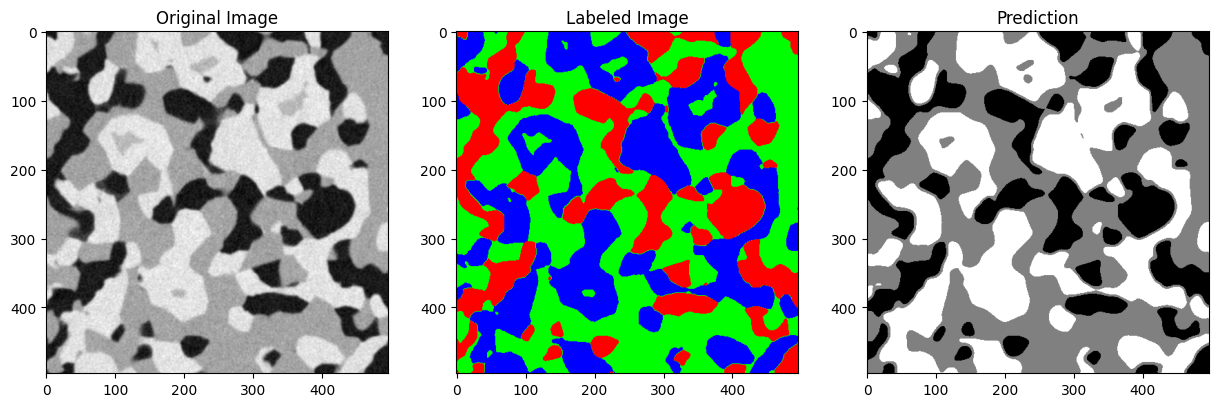

In [67]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))  # Increase the figure size for better visibility

# Plot the original image
plt.subplot(1, 3, 1)  # 1 row, 3 columns, first subplot
plt.imshow(np.swapaxes(inputs[0].cpu(), 0, 2), cmap='gray')
plt.title('Original Image')

# Plot the labeled image
plt.subplot(1, 3, 2)  # 1 row, 3 columns, second subplot
plt.imshow(np.swapaxes(labels[0].cpu(), 0, 2), cmap='gray')  # You might not need cmap='gray' if it's a color label image
plt.title('Labeled Image')

# Plot the prediction image
plt.subplot(1, 3, 3)  # 1 row, 3 columns, third subplot
#plt.imshow(first_pred, cmap='gray')
#plt.imshow(discrete_pred, cmap='gray')
plt.imshow(np.argmax(pred[0].swapaxes(1,2), 0)*0.1, cmap='gray')
#plt.imshow(np.swapaxes(pred[0], 0, 2), cmap='gray')
plt.title('Prediction')

# Show the plot
plt.show()

## OLD
### Another version of the model

In [ ]:
class UNet(nn.Module):
    def __init__(self, n_class):
        super().__init__()
        
        # Encoder
        # In the encoder, convolutional layers with the Conv2d function are used to extract features from the input image. 
        # Each block in the encoder consists of two convolutional layers followed by a max-pooling layer, with the exception of the last block which does not include a max-pooling layer.
        # -------
        # input: 572x572x3
        # NOTE: changed from (3,64) to (1,64)
        self.e11 = nn.Conv2d(1, 64, kernel_size=3, padding=1) # output: 570x570x64
        self.e12 = nn.Conv2d(64, 64, kernel_size=3, padding=1) # output: 568x568x64
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2) # output: 284x284x64

        # input: 284x284x64
        self.e21 = nn.Conv2d(64, 128, kernel_size=3, padding=1) # output: 282x282x128
        self.e22 = nn.Conv2d(128, 128, kernel_size=3, padding=1) # output: 280x280x128
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2) # output: 140x140x128

        # input: 140x140x128
        self.e31 = nn.Conv2d(128, 256, kernel_size=3, padding=1) # output: 138x138x256
        self.e32 = nn.Conv2d(256, 256, kernel_size=3, padding=1) # output: 136x136x256
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2) # output: 68x68x256

        # input: 68x68x256
        self.e41 = nn.Conv2d(256, 512, kernel_size=3, padding=1) # output: 66x66x512
        self.e42 = nn.Conv2d(512, 512, kernel_size=3, padding=1) # output: 64x64x512
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2) # output: 32x32x512

        # input: 32x32x512
        self.e51 = nn.Conv2d(512, 1024, kernel_size=3, padding=1) # output: 30x30x1024
        self.e52 = nn.Conv2d(1024, 1024, kernel_size=3, padding=1) # output: 28x28x1024


        # Decoder
        self.upconv1 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.d11 = nn.Conv2d(1024, 512, kernel_size=3, padding=1)
        self.d12 = nn.Conv2d(512, 512, kernel_size=3, padding=1)

        self.upconv2 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.d21 = nn.Conv2d(512, 256, kernel_size=3, padding=1)
        self.d22 = nn.Conv2d(256, 256, kernel_size=3, padding=1)

        self.upconv3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.d31 = nn.Conv2d(256, 128, kernel_size=3, padding=1)
        self.d32 = nn.Conv2d(128, 128, kernel_size=3, padding=1)

        self.upconv4 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.d41 = nn.Conv2d(128, 64, kernel_size=3, padding=1)
        self.d42 = nn.Conv2d(64, 64, kernel_size=3, padding=1)

        # Output layer
        self.outconv = nn.Conv2d(64, n_class, kernel_size=1)
        
    def forward(self, x):
        # Encoder
        xe11 = relu(self.e11(x))
        xe12 = relu(self.e12(xe11))
        xp1 = self.pool1(xe12)

        xe21 = relu(self.e21(xp1))
        xe22 = relu(self.e22(xe21))
        xp2 = self.pool2(xe22)

        xe31 = relu(self.e31(xp2))
        xe32 = relu(self.e32(xe31))
        xp3 = self.pool3(xe32)

        xe41 = relu(self.e41(xp3))
        xe42 = relu(self.e42(xe41))
        xp4 = self.pool4(xe42)

        xe51 = relu(self.e51(xp4))
        xe52 = relu(self.e52(xe51))
        
        # Decoder
        xu1 = self.upconv1(xe52)
        xu11 = torch.cat([xu1, xe42], dim=1)
        xd11 = relu(self.d11(xu11))
        xd12 = relu(self.d12(xd11))

        xu2 = self.upconv2(xd12)
        xu22 = torch.cat([xu2, xe32], dim=1)
        xd21 = relu(self.d21(xu22))
        xd22 = relu(self.d22(xd21))

        xu3 = self.upconv3(xd22)
        xu33 = torch.cat([xu3, xe22], dim=1)
        xd31 = relu(self.d31(xu33))
        xd32 = relu(self.d32(xd31))

        xu4 = self.upconv4(xd32)
        xu44 = torch.cat([xu4, xe12], dim=1)
        xd41 = relu(self.d41(xu44))
        xd42 = relu(self.d42(xd41))

        # Output layer
        out = self.outconv(xd42)

        return out